In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Load the training/testing dataset from csv files
training_dataset = pd.read_csv("../output_train_orig.csv", header=0, usecols=[*range(1,23)], sep=";")
testing_dataset = pd.read_csv("../output_test.csv", header=0, usecols=[*range(1,23)], sep=";")

# Remove missing values
training_dataset.dropna(axis = 0, inplace = True)
testing_dataset.dropna(axis = 0, inplace = True)

print("The shape of the training dataset: " + str(training_dataset.shape))
print("The shape of the testing dataset: " + str(testing_dataset.shape))

training_dataset.head()

# Set of features in the dataset
features = list(testing_dataset.columns)
print(features[:-1])

# Convert the expected output into arrays, e.g., 1 -> [1, 0, 0]
output_training = []
for i, val in enumerate(training_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_training.append(temp)

output_testing = []
for i, val in enumerate(testing_dataset.iloc[:,21]):
    temp = [0, 0, 0]
    temp[val - 1] = 1
    output_testing.append(temp)

# Remove the expected output column from the datasets
prep_training_dataset = training_dataset.drop(columns=['output'])
prep_testing_dataset = testing_dataset.drop(columns=['output'])

# Preprocessing the data
scaler = StandardScaler()
scaler.fit(prep_training_dataset)

# Apply transform to both the training/testing dataset.
X_train = scaler.transform(prep_training_dataset)
Y_train = np.array(output_training)

X_test = scaler.transform(prep_testing_dataset)
Y_test = np.array(output_testing)

print("Preprocessed inputs of the training dataset: " + str(X_train))
print("Preprocessed outputs of the training dataset: " + str(Y_train))

The shape of the training dataset: (279, 22)
The shape of the testing dataset: (103, 22)
['session_time', '%tcp_protocol', '%udp_protocol', 'ul_data_volume', 'max_ul_volume', 'min_ul_volume', 'avg_ul_volume', 'std_ul_volume', '%ul_volume', 'dl_data_volume', 'max_dl_volume', 'min_dl_volume', 'avg_dl_volume', 'std_dl_volume', '%dl_volume', 'nb_uplink_packet', 'nb_downlink_packet', 'ul_packet', 'dl_packet', 'kB/s', 'nb_packet/s']
Preprocessed inputs of the training dataset: [[ 1.24949172  0.59231316 -0.58844871 ...  0.54501086  0.2208743
   0.62843195]
 [-0.8505485   0.59231316 -0.58844871 ...  0.4955518   0.97523057
   1.92817113]
 [ 0.43816388  0.5886868  -0.58480418 ...  0.04242978  0.0580633
   0.48885055]
 ...
 [-1.2056687   0.34743347 -0.34234218 ... -0.71477922 -0.56070378
  -0.41047599]
 [-0.89460259  0.58409106 -0.58018542 ...  0.10394211  0.44768975
   1.24034932]
 [-0.98176026  0.59231316 -0.58844871 ... -0.62260254  0.43111073
  -0.53651579]]
Preprocessed outputs of the traini

In [4]:
import lightgbm as ltb
from sklearn import metrics
from sklearn.metrics import confusion_matrix

model_ltb = ltb.LGBMRegressor(objective='regression',
                              num_leaves=144,
                              learning_rate=0.005, 
                              n_estimators=1000, 
                              max_depth=12,
                              metric='rmse',
                              is_training_metric=True,
                              max_bin = 55, 
                              bagging_fraction = 0.8,
                              verbose=-1,
                              bagging_freq = 5, 
                              feature_fraction = 0.9)

model = ltb.LGBMClassifier()
# Using Y_train here got an error of shape
model.fit(X_train, training_dataset.iloc[:,21])
    
Y_expected = testing_dataset.iloc[:,21]
Y_predicted = model.predict(X_test)

r_2_score = metrics.r2_score(Y_expected, Y_predicted)
mean_squared_log_error_score = metrics.mean_squared_log_error(Y_expected, Y_predicted)
print("r_2 score: %f" % (r_2_score))
print("mean_squared_log_error score: %f" % (mean_squared_log_error_score))

wrong_preds = []
for i in range(len(Y_expected)):
    if Y_predicted[i] != Y_expected[i]:
        wrong_preds.append(i)

print("Wrong predictions: " + str(wrong_preds))

cm = confusion_matrix(Y_expected, Y_predicted)
print("Confusion matrix: \n" + str(cm))

r_2 score: 0.733253
mean_squared_log_error score: 0.016404
Wrong predictions: [56, 57, 60, 70, 80, 82]
Confusion matrix: 
[[80  0  0]
 [ 0  4  3]
 [ 3  0 13]]


Using 103 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/103 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


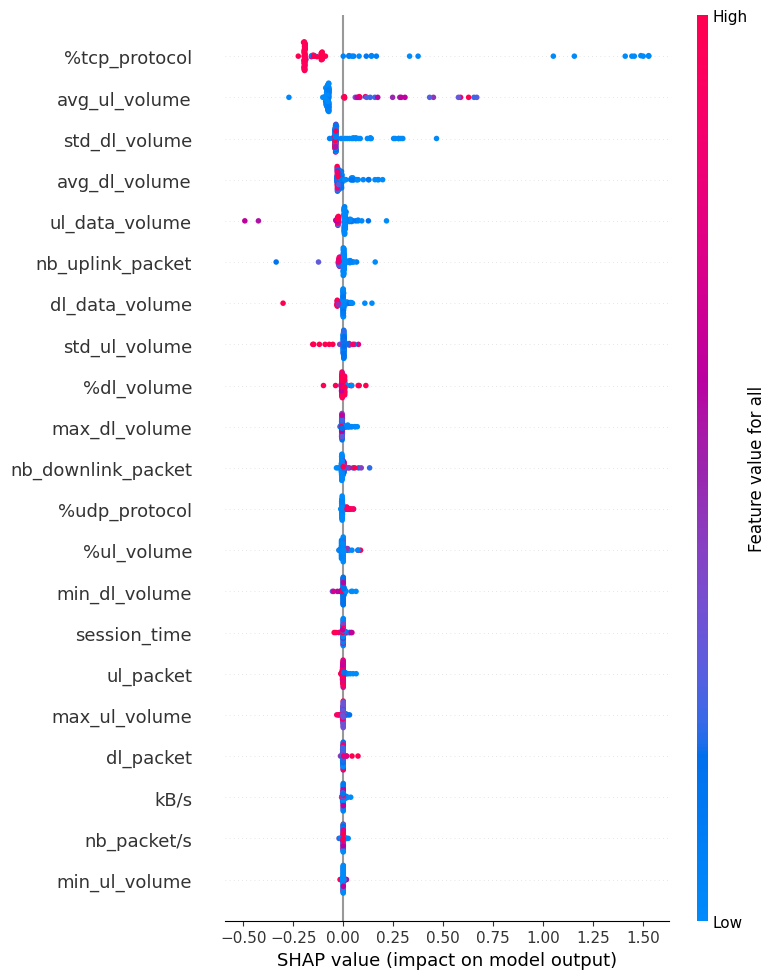

In [10]:
import shap
import warnings

classes=['Web', 'Interactive', 'Video']

ltb_explainer = shap.KernelExplainer(model.predict, X_test)
#ltb_explainer = shap.TreeExplainer(model)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = ltb_explainer.shap_values(X_test)

#shap.summary_plot(shap_values[0], X_test, feature_names=features, max_display=24, 
#                    class_names=classes, color_bar_label='Feature value for Web', plot_type="violin")
#shap.summary_plot(shap_values[1], X_test, feature_names=features, max_display=24, 
#                    class_names=classes, color_bar_label='Feature value for Interactive', plot_type="violin")
#shap.summary_plot(shap_values[2], X_test, feature_names=features, max_display=24, 
#                    class_names=classes, color_bar_label='Feature value for Video', plot_type="violin")

shap.summary_plot(shap_values, X_test, feature_names=features, max_display=24, 
                    class_names=classes, color_bar_label='Feature value for all')

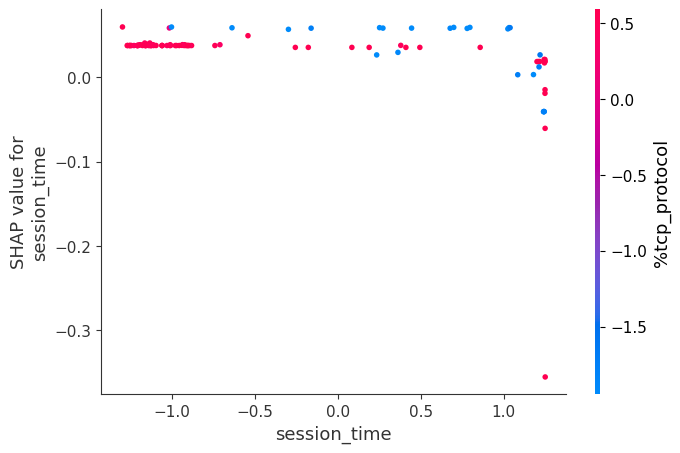

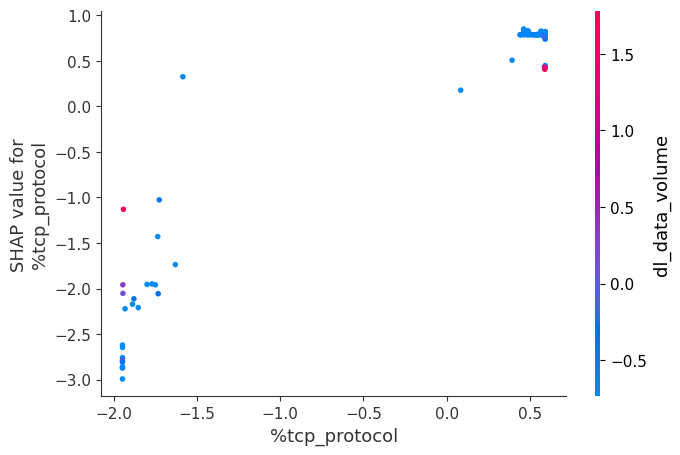

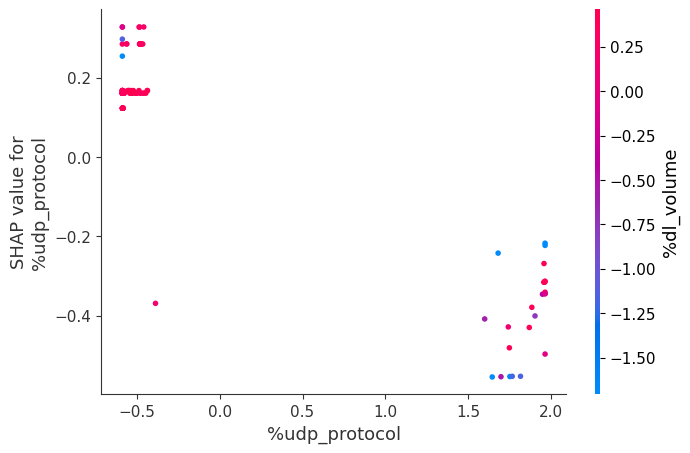

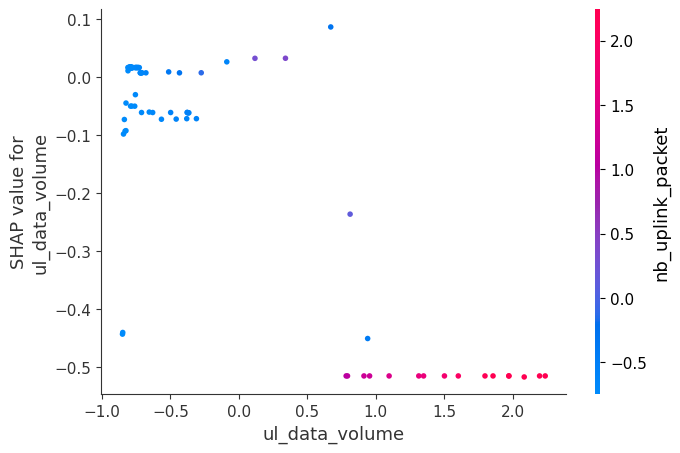

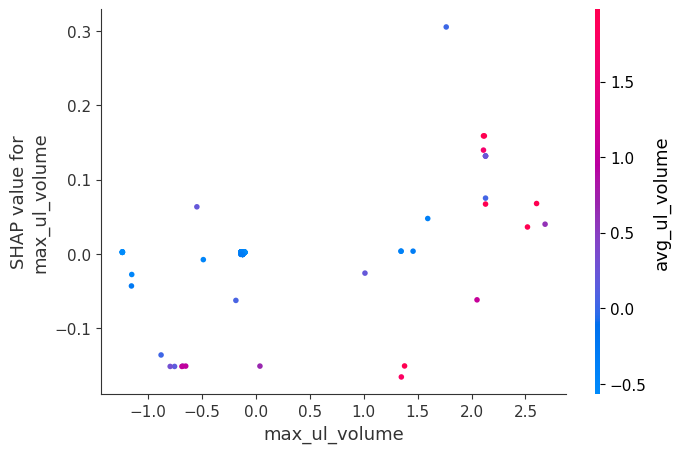

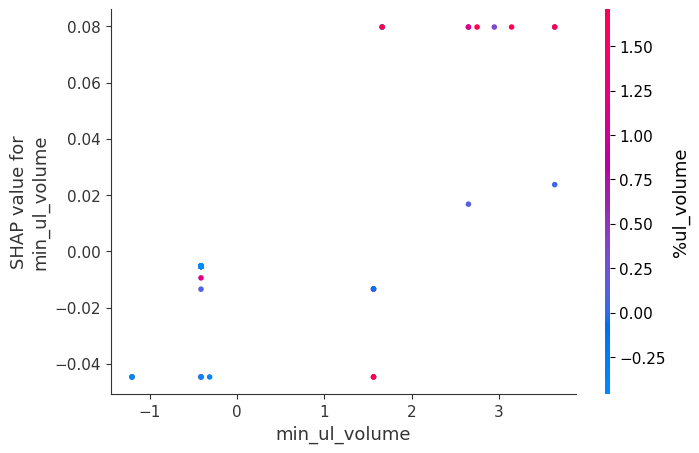

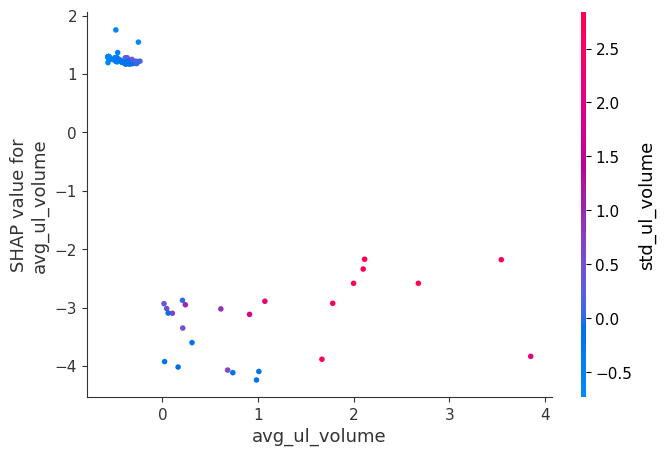

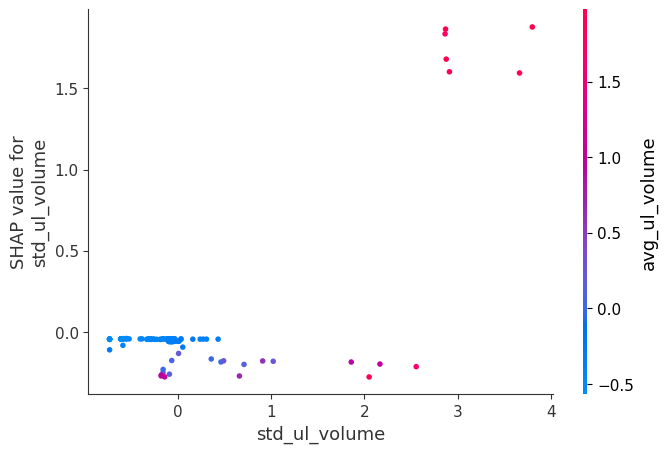

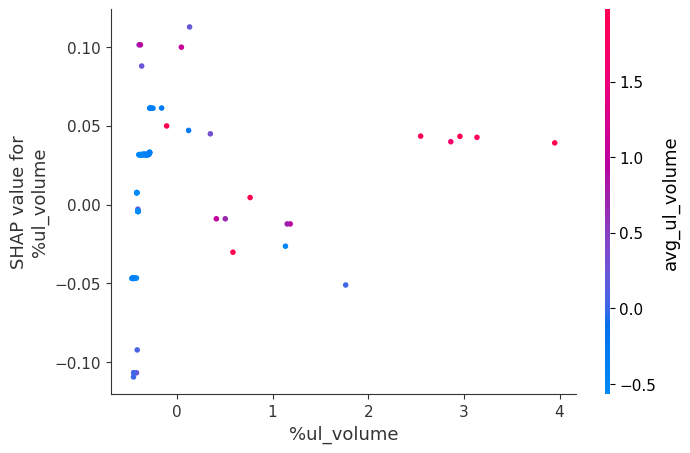

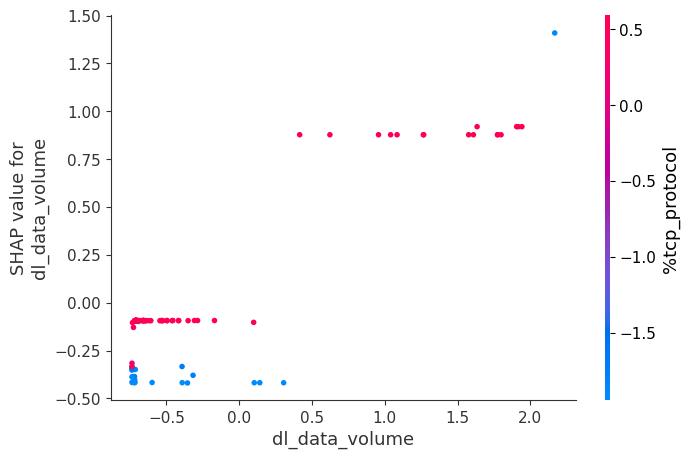

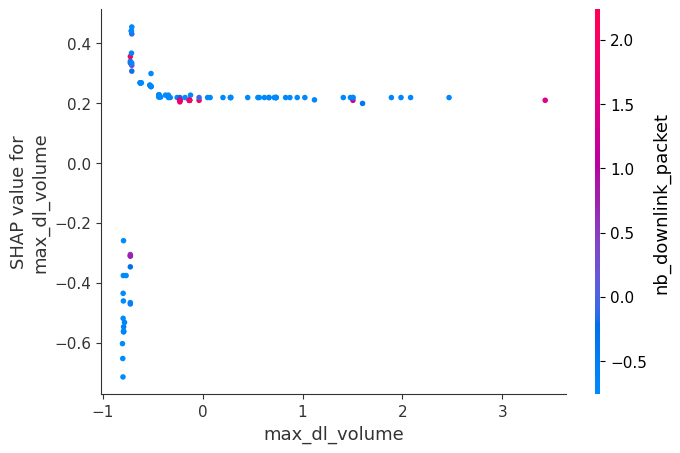

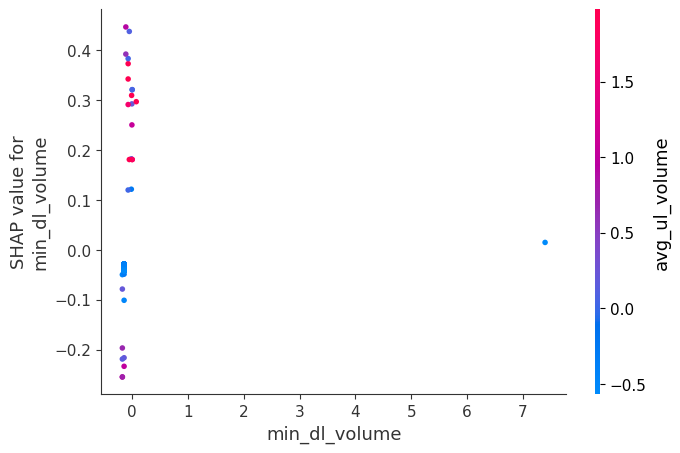

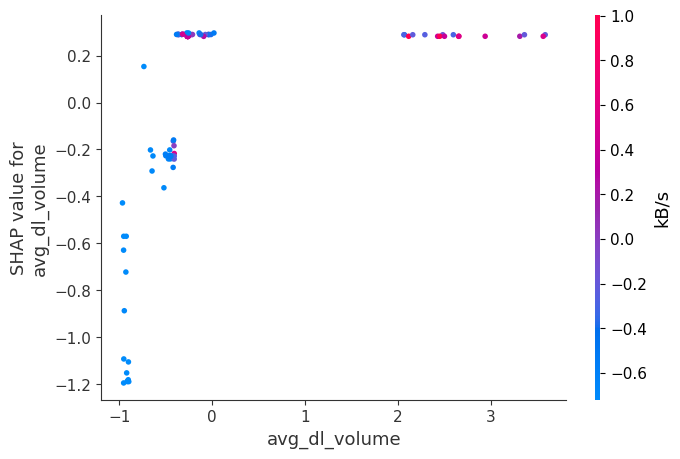

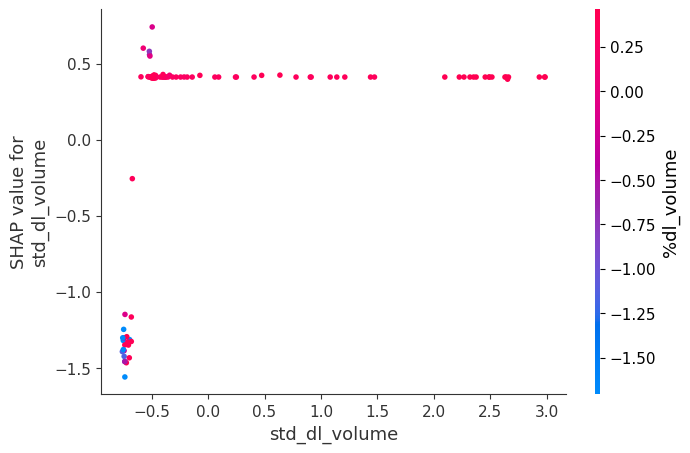

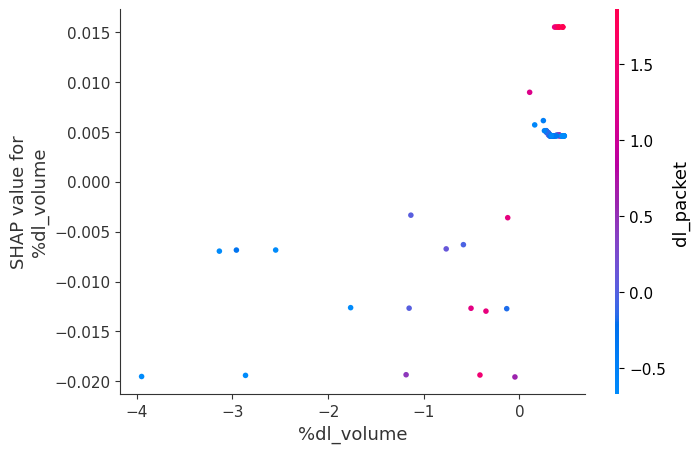

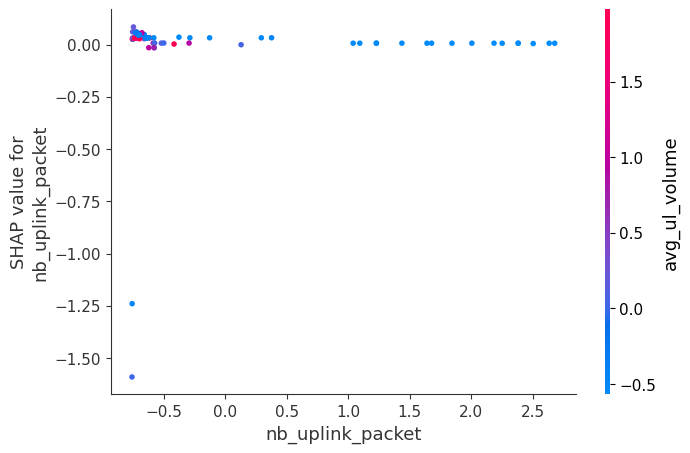

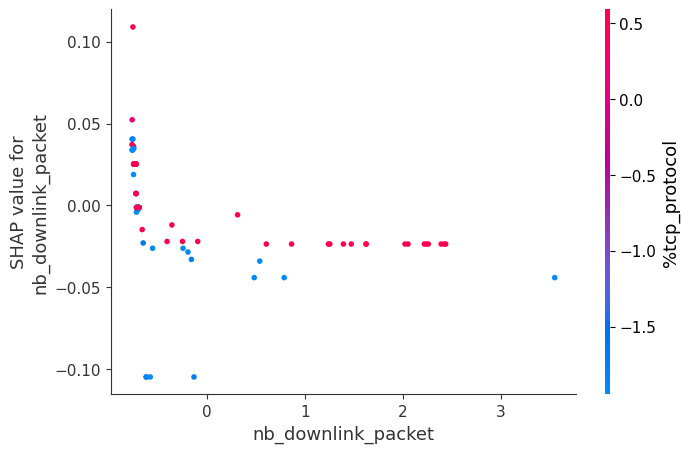

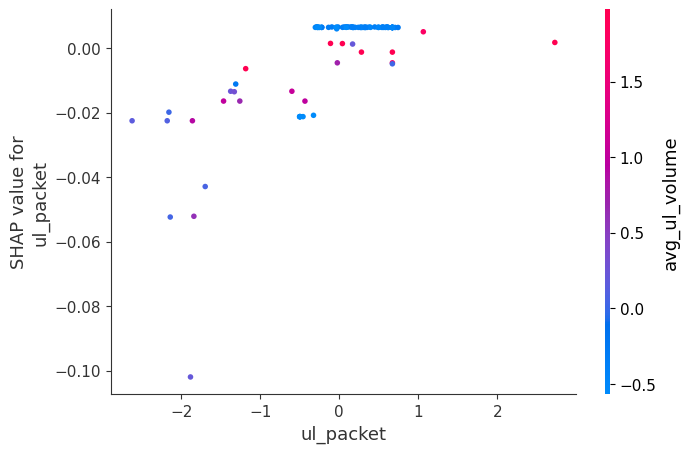

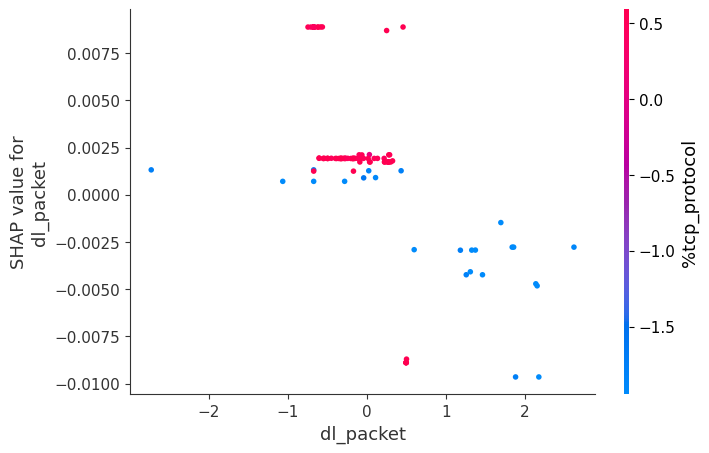

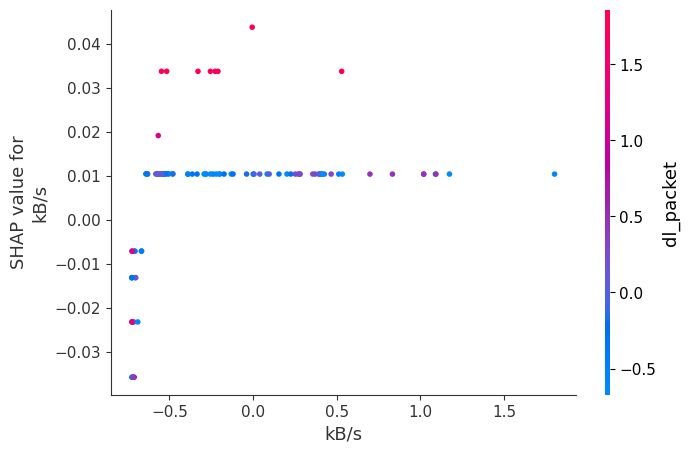

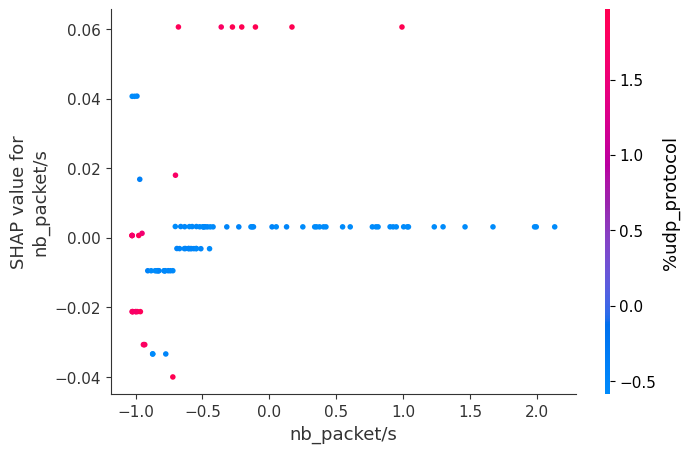

In [13]:
# Dependency plot between a pair of features ??? 
# Only for TreeExplainer, not KernelExplainer?
ltb_explainer = shap.TreeExplainer(model)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = ltb_explainer.shap_values(X_test)

for i in range(len(features[:-1])):
    shap.dependence_plot(i, shap_values[0], X_test, feature_names=features)